In [46]:
import numpy as np 
import matplotlib.pyplot as plt 
from logistics import new_cav_model , J_analytical_new, fourier_transform_matrix, fast_f_t, spectrum_1
from logistics_exact_cavity import Driven_cavity_class,two_modes_cavity
from numpy.fft import fft,fftfreq
from scipy.interpolate import interp1d	

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  


Defino el error 
$$ \epsilon(N_{modes},\gamma \tau) = \frac{1}{t_{max}} \int_{0}^{t_{max}} \sqrt{\rho^{2}_{ee}(u)-\rho^{2}_{ee,N_{modes},\gamma \tau}(u)} du $$


In [2]:
#-------- definitions ------------
from dataclasses import dataclass, field
from scipy.linalg import expm

def mkron(A, *args):
	if len(args) == 0:
		return A
	return np.kron(A, mkron(args[0], *args[1:]))

def b_op(i: int, n: int) -> np.ndarray:
	''' generator of sigma^{-}_{i} operators in the initial state (standard pauli matrices times the identity)'''
	return mkron(np.eye(2**i), [[0, 0], [1, 0]], np.eye(2 ** (n - i - 1))).astype(np.complex128)

@dataclass
class Nmode_cavity:
	omega_qubit :float  = 1 
	coupling: float = 1 
	modes_frequencies:np.ndarray = field(default_factory=lambda: np.array([]))
	Hamiltonian: np.ndarray = field(init=False) 
	psi0: np.ndarray = field(init=False) 
	
	def __post_init__(self):
		N = len(self.modes_frequencies)
		self.Hamiltonian = np.zeros((N+1,N+1),dtype=complex)
		self.Hamiltonian[0,0] = self.omega_qubit
		for n in range(N):
			self.Hamiltonian[n+1,n+1] = self.modes_frequencies[n]
			self.Hamiltonian[n+1,0] = self.coupling
			self.Hamiltonian[0,n+1] = self.coupling
		self.psi0 = np.zeros(len(self.modes_frequencies)+1,dtype=complex)
		self.psi0[0] = 1
	def evolve(self,times):
		vec=[] 
		for t in times:
			U = expm(-1j*self.Hamiltonian*t)
			vec.append(U@self.psi0)
		return np.asarray(vec)
		
		
def FRS(N,tau):
	return  np.arange(-2*(N-1),2*(N+1),2)*np.pi/tau 

def err_est(t,y1,y2): 
	t = np.asarray(t)
	y1 = np.asarray(y1)
	y2 = np.asarray(y2)

	integrand = np.sqrt(np.abs(y1**2 - y2**2))
	integral = np.trapezoid(integrand, t)
	t_max = t[-1] - t[0]

	return integral / t_max




In [ ]:
gamma_0 = 0.2
phi_0 = np.pi
tau_0 = 1 
t_max = 100 * tau_0
dt = tau_0 / 50

phi_values = np.linspace(0, 2*np.pi, 80)   
N_values = np.arange(1, 81)                
gamma_values = np.linspace(0.1,10,80)

def error_map_line(gamma,tau,phi,t_max,dt,Nmodes):
    cavity = new_cav_model(gamma,phi,tau,0)
    cavity.evolve(t_max,dt)
    t,e = cavity.excited_state([1,0])
    exact = Nmode_cavity(phi/tau,np.sqrt(gamma/tau),FRS(Nmodes,tau))
    pe=np.abs(exact.evolve(t)[:,0]**2) 
    return np.abs(err_est(t,e,pe))

def compute_error_point(phi, Nmod):
    return error_map_line(gamma_0, tau_0, phi, t_max, dt, Nmod)

def compute_error_point_2(gamma, Nmod):
    return error_map_line(gamma, tau_0, phi_0, t_max, dt, Nmod)

data = np.load('errores.npz')

# Acceder a los arrays por su nombre
error = data['error']
error_2 = data['error_2']

In [47]:
N_test = [20,40]
gamma_test = 0.5
cavity = new_cav_model(gamma_test,phi_0,tau_0,0)
cavity.evolve(t_max,dt)
t,e = cavity.excited_state([1,0])
p_exact=[]
for Nm in N_test:
	print(Nm)
	exact = Nmode_cavity(phi_0/tau_0,np.sqrt(gamma_test/tau_0),FRS(Nm,tau_0))
	pe=np.abs(exact.evolve(t)[:,0]**2) 
	p_exact.append(pe)

20
40


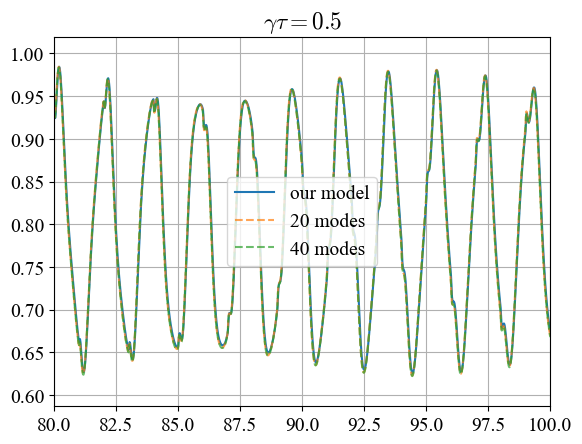

In [48]:
plt.plot(t,e,label='our model')
for n,pe in enumerate(p_exact):
    plt.plot(t,pe,'--',label=rf"{N_test[n]:.0f} modes",alpha=0.7)
plt.grid()
plt.title(rf"$\gamma \tau ={gamma_test*tau_0:.1f}$")

plt.legend()
plt.xlim(80,100)
plt.show()

# 1. $\phi $ Vs $ N_{modes} $ 

In [98]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=80, verbose=5)(
    delayed(compute_error_point)(phi, Nmod)
    for phi in phi_values
    for Nmod in N_values
)

error = np.array(results).reshape(len(phi_values), len(N_values))

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=80)]: Done 128 tasks      | elapsed:  1.4min
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:  3.1min
[Parallel(n_jobs=80)]: Done 488 tasks      | elapsed:  5.2min
[Parallel(n_jobs=80)]: Done 722 tasks      | elapsed:  7.7min
[Parallel(n_jobs=80)]: Done 992 tasks      | elapsed: 10.7min
[Parallel(n_jobs=80)]: Done 1298 tasks      | elapsed: 13.9min
[Parallel(n_jobs=80)]: Done 1640 tasks      | elapsed: 17.5min
[Parallel(n_jobs=80)]: Done 2018 tasks      | elapsed: 21.5min
[Parallel(n_jobs=80)]: Done 2432 tasks      | elapsed: 25.9min
[Parallel(n_jobs=80)]: Done 2882 tasks      | elapsed: 30.6min
[Parallel(n_jobs=80)]: Done 3368 tasks      | elapsed: 35.8min
[Parallel(n_jobs=80)]: Done 3890 tasks      | elapsed: 41.3min
[Parallel(n_jobs=80)]: Done 4448 tasks      | elapsed: 47.3min
[Parallel(n_jobs=80)]: Done 5042 tasks      | e

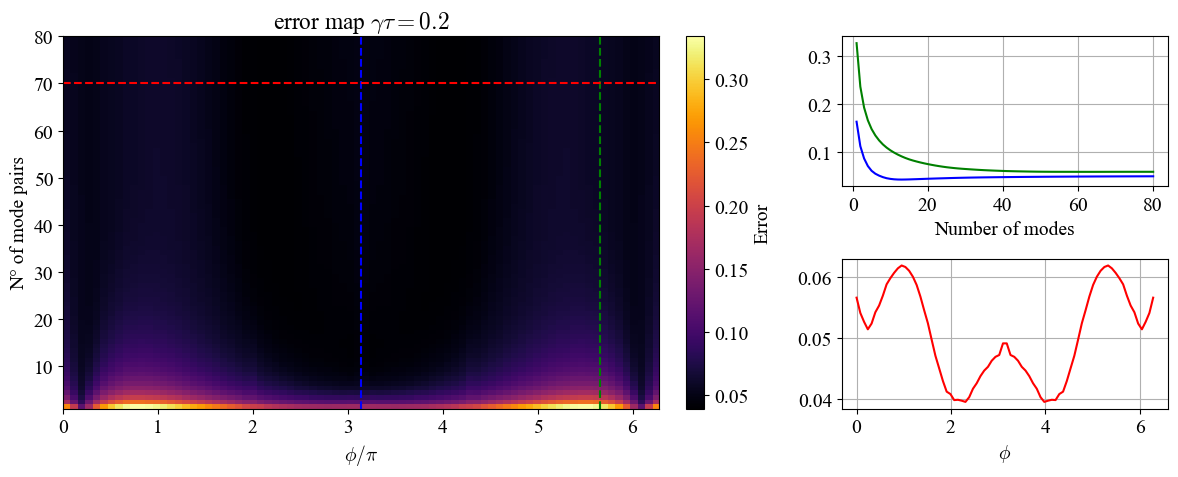

In [45]:
from matplotlib import gridspec
phi_cut_1 = np.pi
phi_cut_2 = 1.8*np.pi
modes_cut=70

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)

ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow(
    error.T,
    origin='lower',
    aspect='auto',
    extent=[phi_values[0], phi_values[-1], N_values[0], N_values[-1]],
    cmap='inferno'
)
ax_heat.set_xlabel(r'$\phi / \pi$')
ax_heat.set_ylabel('N° of mode pairs')
ax_heat.set_title(r'error map $\gamma \tau = 0.2$')

ax_heat.axvline(phi_cut_1, color='b', linestyle='--', linewidth=1.5)
ax_heat.axvline(phi_cut_2, color='g', linestyle='--', linewidth=1.5)
ax_heat.axhline(modes_cut, color='r', linestyle='--', linewidth=1.5)
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label('Error')

ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(N_values, error[np.argmin(np.abs(phi_values-phi_cut_1)),:], 'b')
ax_top.plot(N_values, error[np.argmin(np.abs(phi_values-phi_cut_2)),:], 'g')
ax_top.grid()
ax_top.set_xlabel('Number of modes')

ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.grid()
ax_bottom.plot(phi_values, error[:,np.argmin(np.abs(N_values-modes_cut))], 'r')
ax_bottom.set_xlabel(r'$\phi$' )

plt.tight_layout()
plt.show()


We can stablish the ' number of modes that participate' to those where the derivative changes sign (it starts being worse to add modes)

# 2. $ \gamma \tau $ Vs $N_{modes} $ 

In [101]:
results_2 = Parallel(n_jobs=85, verbose=5)(
    delayed(compute_error_point_2)(gamma, Nmod)
    for gamma in gamma_values
    for Nmod in N_values
)
error_2 = np.array(results_2).reshape(len(gamma_values), len(N_values))

[Parallel(n_jobs=85)]: Using backend LokyBackend with 85 concurrent workers.
[Parallel(n_jobs=85)]: Done 118 tasks      | elapsed:  1.2min
[Parallel(n_jobs=85)]: Done 280 tasks      | elapsed:  3.0min
[Parallel(n_jobs=85)]: Done 478 tasks      | elapsed:  5.1min
[Parallel(n_jobs=85)]: Done 712 tasks      | elapsed:  7.5min
[Parallel(n_jobs=85)]: Done 982 tasks      | elapsed: 10.6min
[Parallel(n_jobs=85)]: Done 1288 tasks      | elapsed: 13.8min
[Parallel(n_jobs=85)]: Done 1630 tasks      | elapsed: 17.5min
[Parallel(n_jobs=85)]: Done 2008 tasks      | elapsed: 21.5min
[Parallel(n_jobs=85)]: Done 2422 tasks      | elapsed: 26.0min
[Parallel(n_jobs=85)]: Done 2872 tasks      | elapsed: 30.8min
[Parallel(n_jobs=85)]: Done 3358 tasks      | elapsed: 36.1min
[Parallel(n_jobs=85)]: Done 3880 tasks      | elapsed: 41.6min
[Parallel(n_jobs=85)]: Done 4438 tasks      | elapsed: 47.6min
[Parallel(n_jobs=85)]: Done 5032 tasks      | elapsed: 54.0min
[Parallel(n_jobs=85)]: Done 5662 tasks      | 

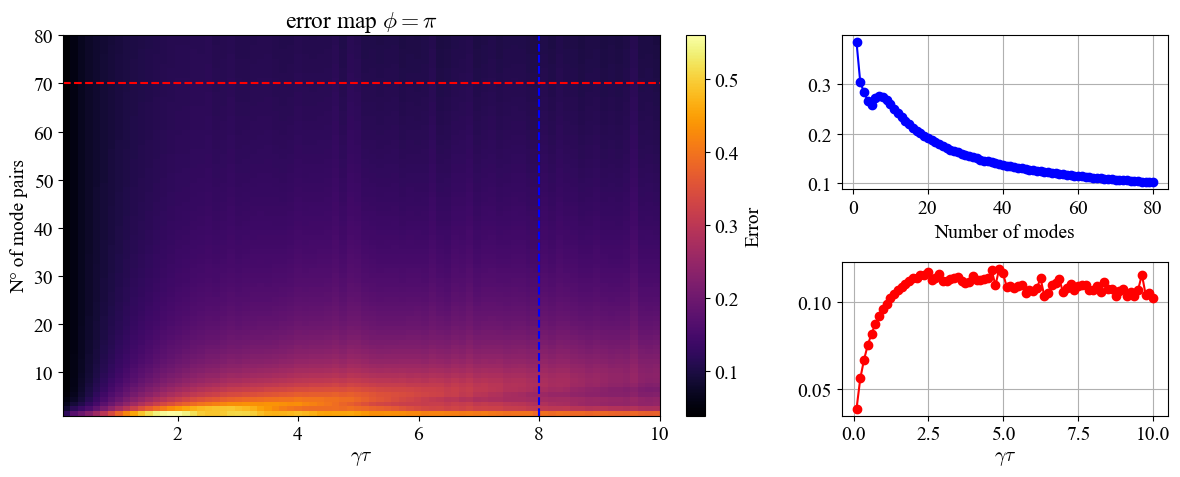

In [38]:
gamma_cut = 8
modes_cut=70

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)

ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow(
    error_2.T,
    origin='lower',
    aspect='auto',
    extent=[gamma_values[0], gamma_values[-1], N_values[0], N_values[-1]],
    cmap='inferno'
)
ax_heat.set_xlabel(r'$\gamma \tau  $')
ax_heat.set_ylabel('N° of mode pairs')
ax_heat.set_title(r'error map $\phi = \pi $')

ax_heat.axvline(gamma_cut, color='b', linestyle='--', linewidth=1.5)
ax_heat.axhline(modes_cut, color='r', linestyle='--', linewidth=1.5)
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label('Error')

ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(N_values, error_2[np.argmin(np.abs(gamma_values-gamma_cut)),:], 'b-o')
ax_top.grid()
ax_top.set_xlabel('Number of modes')

ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.grid()
ax_bottom.plot(gamma_values, error_2[:,np.argmin(np.abs(N_values-modes_cut))], 'r-o')
ax_bottom.set_xlabel(r'$\gamma \tau $' )

plt.tight_layout()
plt.show()


Conclusiones de mi investigacion en la literatura: 
1. El single excitation problem ya esta mirado, con solucion analítica y todo.
2. Hasta donde yo se, nadie ha mirado el Driving. También es el punto donde nuestro método hace las cosas mas raras. 